# Post Match (aka Assessment Framework)

In [144]:
import sys
from pathlib import Path
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np

import src.bikewaysim_functions as bikewaysim_functions

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

import impedance_calibration.stochastic_optimization as stochastic_optimization
from network.src import modeling_turns

## ODS

In [145]:
# import matched ODS (i.e. already have the correct network nodes)
od_matrix = pd.read_csv(config['bikewaysim_fp']/'od_matrix.csv')
ods = list(set(zip(od_matrix['orig_N'],od_matrix['dest_N'])))

In [146]:
#TODO find how many ods failed to find a shortest path
#od_matrix.loc[od_matrix['current_impedance'].isna(),'trips'].sum()

In [147]:
# import test case/ base case (think of a better word) network
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
# import the calibration results
# with (config['calibration_fp']/"calibration_results.pkl").open('rb') as fh:
#     calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)


## Export Existing Infra

In [148]:
existing_infra = links[links['facility_fwd'].notna()]
existing_infra = existing_infra[['linkid','facility_fwd','geometry']].drop_duplicates()
existing_infra.to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='Existing Bicycle Facilities')

# Network Import

In [149]:
current_links = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='current_network') 
improvements = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvements',ignore_geometry=True)
future_links = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='future_network',ignore_geometry=True)
#TODO can only do this because no new network links were added
links = pd.merge(current_links,future_links[['linkid','reverse_link','multiplier','link_cost']],on=['linkid','reverse_link'])
links.rename(columns={'link_cost_x':'current_link_cost','link_cost_y':'future_link_cost','multiplier_x':'current_multiplier','multiplier_y':'future_multiplier'},inplace=True)
links = pd.merge(links,improvements,on='linkid',how='left')

print(current_links.shape)
print(future_links.shape)
print(links.shape)
print(improvements.shape)

(111192, 6)
(111192, 5)
(116452, 10)
(6332, 3)


# Get link impedance reduction from improvements

57 unique projects


<Axes: >

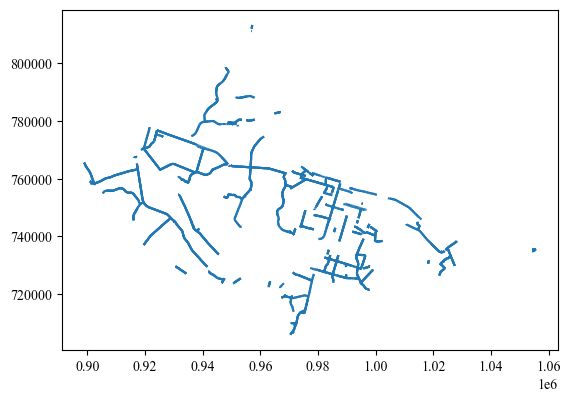

In [150]:
print(links[f"{config['mod_name']}_id"].nunique(),'unique projects')
links[links[f"{config['mod_name']}_id"].notna()].plot()

Get base link impedance reduction

In [151]:
links['impedance_reduction'] = links['future_multiplier'] - links['current_multiplier']
links['impedance_reduction'].describe()

count    116452.000000
mean         -0.038599
std           0.116728
min          -0.562000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.000000
Name: impedance_reduction, dtype: float64

In [152]:
max_impedance_reduction = links[links['impedance_reduction']<0].groupby('linkid')['impedance_reduction'].idxmin()
link_impedance_reduction = links.loc[max_impedance_reduction]
link_impedance_reduction.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='link_impedance_reduction')

In [153]:
undirected_links = links[links['reverse_link']==False]

# Import Routing Results

In [154]:
with (config['bikewaysim_fp']/"current_shortest_results.pkl").open('rb') as fh:
    shortest_results_dict = pickle.load(fh)

with (config['bikewaysim_fp']/"current_results.pkl").open('rb') as fh:
    current_results_dict = pickle.load(fh)

with (config['bikewaysim_fp']/"future_results.pkl").open('rb') as fh:
    future_results_dict = pickle.load(fh)

# Calculate trip travel time/impedance changes

In [155]:
#BUG in the travel time dict, there an int stored as an edge instead of the normal (linkid reverse link)
#current_results_dict.get((67124310.0, 5218791368.0))['edge_list']
x = []
for key, item in current_results_dict.items():
    current_results_dict[key]['edge_list'] = [edge for edge in item['edge_list'] if isinstance(edge,int)==False] 

In [156]:
travel_time_dict = dict(zip(links['linkid'],links['travel_time_min']))

current_tt = {key: np.sum([travel_time_dict.get(edge[0],0) for edge in item['edge_list']]) for key, item in current_results_dict.items()}
future_tt = {key: np.sum([travel_time_dict.get(edge[0],0) for edge in item['edge_list']]) for key, item in future_results_dict.items()}
shortest_tt = {key: np.sum([travel_time_dict.get(edge[0],0) for edge in item['edge_list']]) for key, item in shortest_results_dict.items()}

od_matrix['current_tt_min'] = [current_tt.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]
od_matrix['future_tt_min'] = [future_tt.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]
od_matrix['shortest_tt_min'] = [shortest_tt.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]

current_impedance = {key:item['length'] for key, item in current_results_dict.items()}
future_impedance = {key:item['length'] for key, item in future_results_dict.items()}

od_matrix['current_impedance'] = [current_impedance.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]
od_matrix['future_impedance'] = [future_impedance.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]

# Impedance Change for trips

Weighted reduction

In [157]:
od_matrix['impedance_reduction'] = (od_matrix['current_impedance'] - od_matrix['future_impedance'])
maen_reduction = (od_matrix['impedance_reduction'] * od_matrix['trips']).sum() / od_matrix['trips'].sum()
print(f'The weighted average reduction in impedance was {round(maen_reduction,2)} minutes')

The weighted average reduction in impedance was 1.82 minutes


In [158]:
# distribution isn't too meaningful
# import matplotlib.pyplot as plt
# plt.hist(od_matrix['impedance_reduction'],weights=od_matrix['trips'],bins=20)

In [159]:
max_reduction = od_matrix['impedance_reduction'].max() #* od_matrix['trips']).sum() / od_matrix['trips'].sum()
print(f"The max reduction in impedance was {round(max_reduction,2)} minutes")

The max reduction in impedance was 14.6 minutes


In [160]:
# some difference if aggregating to the destination taz but it's not too different
# trip_impedance_reduction = od_matrix.groupby('dest_taz').apply(lambda x: ((x.current_impedance-x.future_impedance) * x.trips).sum() / x.trips.sum())
# #studyarea = gpd.read_file(config['studyarea_fp'])
# tazs = gpd.read_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')#,mask=studyarea)
# tazs['impedance_change'] = tazs['tazid'].map(trip_impedance_reduction)
# tazs.plot('impedance_change')

<Axes: >

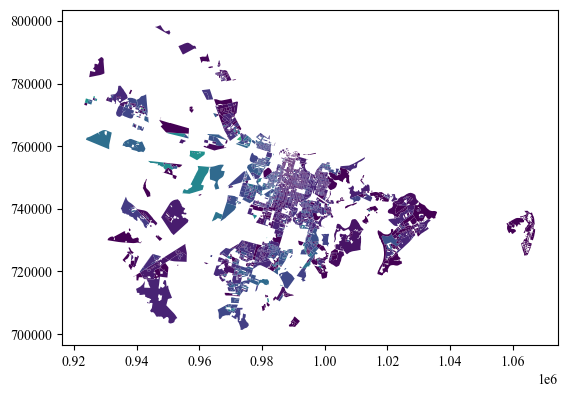

In [161]:
trip_impedance_reduction = od_matrix.groupby('orig_taz').apply(lambda x: ((x.current_impedance-x.future_impedance) * x.trips).sum() / x.trips.sum())
#studyarea = gpd.read_file(config['studyarea_fp'])
#tazs = gpd.read_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')#,mask=studyarea)
tazs = gpd.read_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')#,mask=studyarea)
tazs['impedance_change'] = tazs['tazid'].map(trip_impedance_reduction)
tazs.plot('impedance_change')

In [162]:
tazs[tazs['impedance_change']==0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='origin_weighted_impedance_nochange')
tazs[tazs['impedance_change']>0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='origin_weighted_impedance_change')

# Percent Detour

In [163]:
# od_matrix['detour'] = od_matrix['current_tt_min'] - od_matrix['shortest_tt_min']
# detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.detour * x.trips).sum() / x.trips.sum())
# #od_matrix.hist(od_matrix['detour'],bins=50,weights=od_matrix['trips'])
# tazs['detour'] = tazs['tazid'].map(detour)
# tazs.plot('detour')

In [164]:
od_matrix['percent_detour'] = ((od_matrix['current_tt_min'] - od_matrix['shortest_tt_min']) / od_matrix['shortest_tt_min'] * 100)#.round(1)
od_matrix['percent_detour'].describe()

count    13617.000000
mean         0.815970
std          1.734299
min          0.000000
25%          0.000000
50%          0.116303
75%          0.703522
max         19.248462
Name: percent_detour, dtype: float64

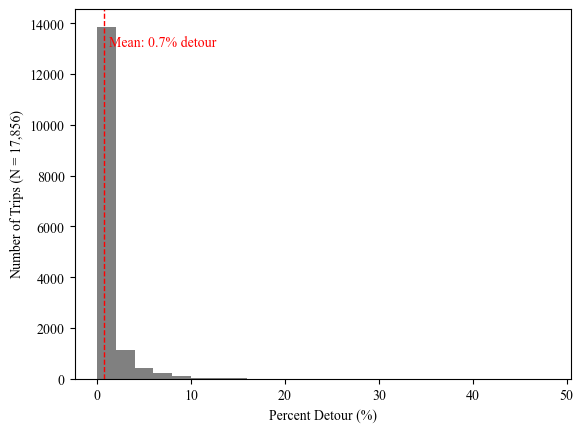

In [165]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.hist(od_matrix['percent_detour'], bins=range(0, 50, 2), weights=od_matrix['trips'], color='grey')
plt.grid(False)
plt.xlabel(f"Percent Detour (%)")
plt.ylabel(f"Number of Trips (N = {od_matrix['trips'].sum():,})")
# Add vertical red line at the mean value
mean_percent_detour = (od_matrix['percent_detour'] * od_matrix['trips']).sum() / od_matrix['trips'].sum()
plt.axvline(mean_percent_detour, color='red', linestyle='dashed', linewidth=1)
# Add label for the mean value
plt.text(od_matrix['percent_detour'].mean() * 1.5, plt.gca().get_ylim()[1] * 0.9, f"Mean: {mean_percent_detour:,.1f}% detour", color='red', ha='left')
plt.show()

In [166]:
percent_detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.percent_detour * x.trips).sum() / x.trips.sum())
percent_detour.describe()

count    2921.000000
mean        0.665424
std         1.108999
min         0.000000
25%         0.000000
50%         0.256485
75%         0.837286
max        15.345511
dtype: float64

<Axes: >

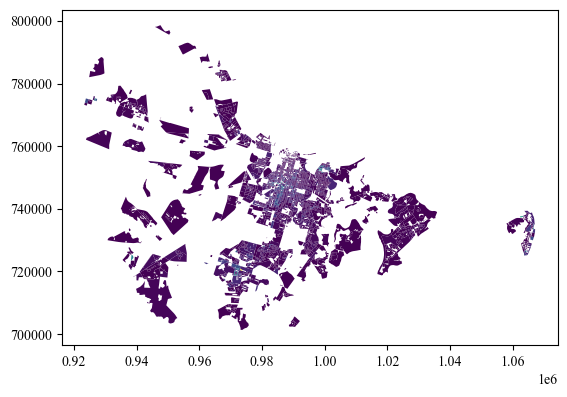

In [167]:
# tazs = gpd.read_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')
tazs = gpd.read_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')#,mask=studyarea)
tazs['percent_detour'] = tazs['tazid'].map(percent_detour)
tazs.plot('percent_detour')

In [168]:
tazs.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='percent_detour')

## Percent Detour Change Due to Network Improvements (future)

In [169]:
od_matrix['improved_percent_detour'] = ((od_matrix['future_tt_min'] - od_matrix['shortest_tt_min']) / od_matrix['shortest_tt_min'] * 100)#.round(1)
improved_percent_detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.improved_percent_detour * x.trips).sum() / x.trips.sum())
improved_percent_detour.describe()

count    2921.000000
mean        2.285147
std         2.960728
min         0.000000
25%         0.143949
50%         1.231766
75%         3.222261
max        26.215505
dtype: float64

In [170]:
# tazs['improved_percent_detour'] = tazs['tazid'].map(improved_percent_detour)
# tazs['percent_detour_change'] = tazs['improved_percent_detour'] - tazs['percent_detour']
# tazs['percent_detour_change'].hist()

In [171]:
# tazs.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='percent_detour')

# Link Betweenness Centrality (LBC)
We need this to visualize how trips shifted and to detemrine the impedance reduction contribution of each project.

In [172]:
#directed is number of trips by direction, undirected is combined number of trips
shortest_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
shortest_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}
current_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
current_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}
future_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
future_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}

dict_keys = list(set.union(set(current_results_dict.keys()),set(future_results_dict.keys())))
for od_pair in dict_keys:
    #get number of trips for that origin node and destinnation node
    o_check = od_matrix['orig_N']==od_pair[0]
    d_check = od_matrix['dest_N']==od_pair[1]
    num_trips = od_matrix.loc[o_check & d_check,'trips'].sum()
    
    #retreive the edge list
    shortest_modeled_edges = shortest_results_dict.get(od_pair,0)
    current_modeled_edges = current_results_dict.get(od_pair,0)
    future_modeled_edges = future_results_dict.get(od_pair,0)
    
    #current
    if shortest_modeled_edges != 0:
        #retrieve the edge list
        shortest_modeled_edges = [tuple(x) for x in shortest_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in shortest_modeled_edges:
            shortest_directed_btw_centrality[edge] += num_trips
            shortest_undirected_btw_centrality[edge[0]] += num_trips

    #current
    if current_modeled_edges != 0:
        #retrieve the edge list
        current_modeled_edges = [tuple(x) for x in current_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in current_modeled_edges:
            current_directed_btw_centrality[edge] += num_trips
            current_undirected_btw_centrality[edge[0]] += num_trips
    #future
    if future_modeled_edges != 0:
        #retrieve the edge list
        future_modeled_edges = [tuple(x) for x in future_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in future_modeled_edges:
            future_directed_btw_centrality[edge] += num_trips
            future_undirected_btw_centrality[edge[0]] += num_trips

#only keep non_zero entries
shortest_undirected_btw_centrality = {key:item for key,item in shortest_undirected_btw_centrality.items() if item > 0}
shortest_directed_btw_centrality = {key:item for key,item in shortest_directed_btw_centrality.items() if item > 0}
current_undirected_btw_centrality = {key:item for key,item in current_undirected_btw_centrality.items() if item > 0}
current_directed_btw_centrality = {key:item for key,item in current_directed_btw_centrality.items() if item > 0}
future_undirected_btw_centrality = {key:item for key,item in future_undirected_btw_centrality.items() if item > 0}
future_directed_btw_centrality = {key:item for key,item in future_directed_btw_centrality.items() if item > 0}            

#turn to dataframe
# directed btw centrality useful for directed bike facilities
df0 = pd.DataFrame.from_dict(shortest_directed_btw_centrality,orient='index',columns=['shortest_btw_centrality'])
df1 = pd.DataFrame.from_dict(current_directed_btw_centrality,orient='index',columns=['current_btw_centrality'])
df2 = pd.DataFrame.from_dict(future_directed_btw_centrality,orient='index',columns=['future_btw_centrality'])
directed_btw_centrality = pd.concat([df0,df1,df2],ignore_index=False,axis=1)
directed_btw_centrality.fillna(0,inplace=True)

df0 = pd.DataFrame.from_dict(shortest_undirected_btw_centrality,orient='index',columns=['shortest_btw_centrality'])
df1 = pd.DataFrame.from_dict(current_undirected_btw_centrality,orient='index',columns=['current_btw_centrality'])
df2 = pd.DataFrame.from_dict(future_undirected_btw_centrality,orient='index',columns=['future_btw_centrality'])
undirected_btw_centrality = pd.concat([df0,df1,df2],ignore_index=False,axis=1)
undirected_btw_centrality.fillna(0,inplace=True)
undirected_btw_centrality.reset_index(inplace=True)
undirected_btw_centrality.rename(columns={'index':'linkid'},inplace=True)

#calculate the change
directed_btw_centrality['impedance_change'] = directed_btw_centrality['current_btw_centrality'] - directed_btw_centrality['shortest_btw_centrality']
undirected_btw_centrality['impedance_change'] = undirected_btw_centrality['current_btw_centrality'] - undirected_btw_centrality['shortest_btw_centrality']

directed_btw_centrality['improvement_change'] = directed_btw_centrality['future_btw_centrality'] - directed_btw_centrality['current_btw_centrality']
undirected_btw_centrality['improvement_change'] = undirected_btw_centrality['future_btw_centrality'] - undirected_btw_centrality['current_btw_centrality']

#and pct change
#undirected_btw_centrality['pct_change'] = undirected_btw_centrality['change'] / undirected_btw_centrality['current_btw_centrality'] * 100


In [173]:
#add geometry data
undirected_btw_centrality_gdf = pd.merge(undirected_btw_centrality,undirected_links,on='linkid')
undirected_btw_centrality_gdf = gpd.GeoDataFrame(undirected_btw_centrality_gdf,geometry='geometry',crs=config['projected_crs_epsg'])

Plot change in LBC going from minimum travel time LBC to impedance LBC (both on current network)

<Axes: >

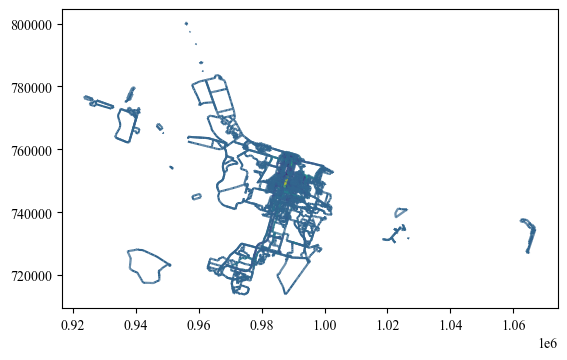

In [174]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['impedance_change']!=0].plot('impedance_change')

Plot change in LBC going from impednace LBC on current network to impedance LBC on future network

<Axes: >

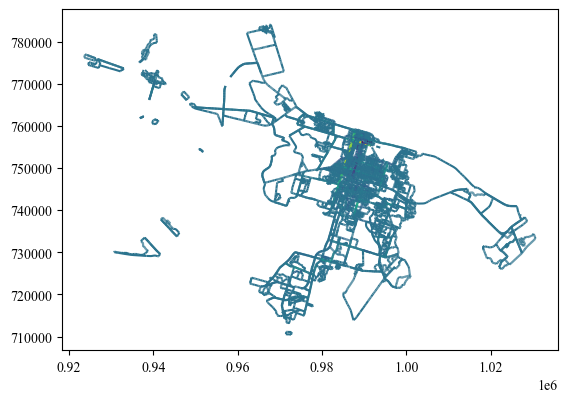

In [175]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['improvement_change']!=0].plot('improvement_change')

In [176]:
undirected_btw_centrality_gdf.describe()

,linkid,shortest_btw_centrality,current_btw_centrality,future_btw_centrality,impedance_change,improvement_change,travel_time_min,current_multiplier,current_link_cost,future_multiplier,future_link_cost,impedance_reduction
count,2.675900e+04,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000
mean,1.125644e+09,51.406929,51.034045,60.363055,-0.372884,9.329011,0.248243,0.146325,0.285470,0.072324,0.265569,-0.074001
std,3.410951e+04,111.527092,121.537078,175.802489,72.603992,133.504887,0.329079,0.064239,0.379242,0.153015,0.357202,0.153592
min,1.125566e+09,0.000000,0.000000,0.000000,-703.000000,-1047.000000,0.001782,-0.272000,0.002006,-0.272000,0.001677,-0.562000
25%,1.125618e+09,4.000000,4.000000,3.000000,-1.000000,-3.000000,0.065119,0.126000,0.074419,0.126000,0.068542,0.000000
50%,1.125647e+09,14.000000,14.000000,11.000000,0.000000,0.000000,0.155797,0.126000,0.178374,0.126000,0.163795,0.000000
75%,1.125675e+09,48.000000,47.000000,39.000000,1.000000,1.000000,0.310084,0.126000,0.356159,0.126000,0.329842,0.000000
max,1.125695e+09,1781.000000,1813.000000,1819.000000,1474.000000,1693.000000,12.208932,0.577000,11.607166,0.577000,11.607166,0.000000


Export GPKGs for visualization in QGIS

In [177]:
#travel time lbc
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['shortest_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_shortest')
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['current_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_current')
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['future_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_future')

undirected_btw_centrality_gdf.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_impedance_change')
undirected_btw_centrality_gdf.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_improvement_change')

## Impedance Reduction Contribution 

### Multiply Link Impedance Reduction by Betweenness Centrality for the Improved Links

<Axes: >

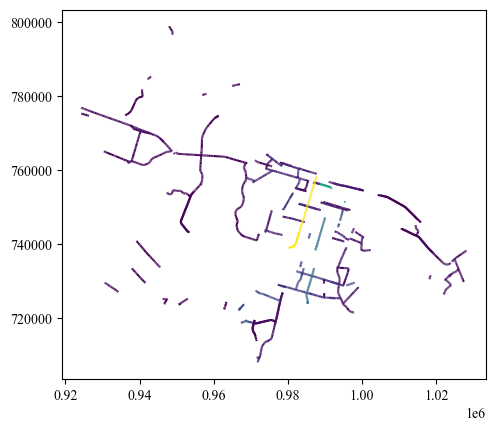

In [178]:
undirected_btw_centrality_gdf['impedance_contribution'] = undirected_btw_centrality_gdf['impedance_reduction'] * undirected_btw_centrality_gdf['future_btw_centrality']
undirected_btw_centrality_gdf['length'] = undirected_btw_centrality_gdf.length
bike_facility = undirected_btw_centrality_gdf[undirected_btw_centrality_gdf[f"{config['mod_name']}_id"].notna()]
bike_facility_geo = bike_facility.dissolve(f"{config['mod_name']}_id")[['geometry']]
impedance_contribution = bike_facility.groupby(f"{config['mod_name']}_id")[['impedance_contribution','length']].sum().abs()
impedance_contribution = pd.concat([impedance_contribution,bike_facility_geo],axis=1,ignore_index=False)
impedance_contribution['impedance_contribution_per_ft'] = impedance_contribution['impedance_contribution'] / impedance_contribution['length']
impedance_contribution = gpd.GeoDataFrame(impedance_contribution,crs=config['projected_crs_epsg'])
impedance_contribution.plot('impedance_contribution_per_ft')

,impedance_contribution,length,geometry,impedance_contribution_per_ft
savannah_id,,,,
37th St Corridor,4746.150,12336.585804,"MULTILINESTRING ((988269.118 749374.238, 98886...",0.384722
Airport/Gulfstream Corridors,141.688,2360.026459,"MULTILINESTRING ((956919.617 780271.528, 95693...",0.060037
Bee Rd Connector,7211.362,8834.656926,"MULTILINESTRING ((994990.927 749694.667, 99491...",0.816258
Benton Blvd Corridor,21.276,8544.785404,"MULTILINESTRING ((948250.807 798235.191, 94822...",0.002490
Berwick/Southbridge Corridor,17.050,14575.898514,"MULTILINESTRING ((950771.793 754399.611, 95046...",0.001170
Bloomingdale/Little Neck Corri,44.576,10759.718717,"MULTILINESTRING ((941531.574 729619.472, 94160...",0.004143
Bona Bella Corridor,575.508,6649.262873,"MULTILINESTRING ((993538.645 733653.791, 99371...",0.086552
Cloverdale/West Gwinnett Corri,864.456,6148.815638,"MULTILINESTRING ((982165.839 755112.689, 98230...",0.140589
Coastal Georgia Greenway,84.940,13357.445837,"MULTILINESTRING ((934681.581 763270.850, 93391...",0.006359


In [180]:
impedance_contribution.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='impedance_contribution')

In [185]:
impedance_contribution = impedance_contribution[['impedance_contribution_per_ft','impedance_contribution','length']]
impedance_contribution.reset_index(inplace=True)
impedance_contribution['impedance_contribution_per_ft'] = impedance_contribution['impedance_contribution_per_ft'].round(2)
impedance_contribution['impedance_contribution'] = impedance_contribution['impedance_contribution'].round(2)
impedance_contribution['length'] = impedance_contribution['length'].round(0)
impedance_contribution.sort_values('impedance_contribution_per_ft',ascending=False,inplace=True)

## Unfinished past here

Merge improvement with the cycling faciliity geodataframe

In [141]:
new_facilities = gpd.read_file(config['bicycle_facilities_fp']/'network_modifications.gpkg',layer=config['mod_name'])
new_facilities = new_facilities[[f"{config['mod_name']}_id",f"{config['mod_name']}_name",f"{config['mod_name']}_osm_type"]]
impedance_contribution = pd.merge(impedance_contribution,new_facilities,on=f"{config['mod_name']}_id")
impedance_contribution = impedance_contribution[[f"{config['mod_name']}_name",f"{config['mod_name']}_osm_type",'impedance_contribution_per_ft','impedance_contribution', 'length']]

Format and export csv

In [188]:
impedance_contribution.to_csv(config['bikewaysim_fp']/'impedance_contribution.csv',index=False)
impedance_contribution.head(10)

,savannah_id,impedance_contribution_per_ft,impedance_contribution,length
31,Montgomery St Corridor,3.30,138364.30,41968.0
27,Liberty/Wheaton Corridor,1.88,14428.30,7679.0
34,Paulsen/Waters Corridor,1.15,44223.77,38431.0
2,Bee Rd Connector,0.82,7211.36,8835.0
32,North-South Corridor,0.71,31528.37,44688.0
14,Eisenhower Corridor,0.55,17061.08,31129.0
30,Montgomery Cross Rd Corridor,0.46,15991.04,34854.0
44,Truman Greenway,0.46,617.38,1342.0
25,Lathrop and Stiles Corridor,0.43,9072.01,20963.0
0,37th St Corridor,0.38,4746.15,12337.0


In [ ]:
impedance_contribution['impedance_contribution_per_ft'] = impedance_contribution['impedance_contribution_per_ft'].astype(int)
impedance_contribution['length'] = impedance_contribution['length'].astype(int)


In [ ]:
impedance_contribution = bike_facility.groupby(f"config['mod_id']}")[['impedance_contribution','length']].sum().abs()
#impedance_contribution = (impedance_contribution['impedance_contribution'] / impedance_contribution['length']).sort_values()

In [ ]:
impedance_contribution

In [ ]:
undirected_btw_centrality_gdf['improvement_impedance_reduction'] = undirected_btw_centrality_gdf['config['mod_id']'].map(test)

In [ ]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['config['mod_id']'].notna()].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvement_impedance_reduction')
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['config['mod_id']'].isna()]

In [ ]:

#import the ones with names too
improvements

In [ ]:
improvements[['facility_fwd_new','config['mod_id']']].drop_duplicates()

In [ ]:
test['impedance_reduction'] (undirected_btw_centrality_gdf['future_link_cost'] - undirected_btw_centrality_gdf['current_link_cost'])

In [ ]:
undirected_links

In [ ]:
improvements.head()

In [ ]:
undirected_btw_centrality_gdf.head()

In [ ]:
test = pd.merge(test,facility_ids,on='linkid',how='left')

In [ ]:
test['impedance_change_cont'] = test['counts'] * test['impedance_change']

In [ ]:
#import the coa id back in so that we can aggregate by the faciility
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer='coa')[['config['mod_id']','linkid']]

In [ ]:
result = test[test['impedance_change_cont']>0].groupby(['config['mod_id']','improvement'])['impedance_change_cont'].sum().sort_values(ascending=False)
result.reset_index(inplace=True)

In [ ]:
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer='coa')
facility_ids = facility_ids.dissolve('config['mod_id']').reset_index()

In [ ]:
facility_ids = pd.merge(facility_ids,result,on='config['mod_id']')
facility_ids.explore('impedance_change_cont')

In [ ]:
results_dict

In [ ]:
#od_matrix['current_impedance'] = 
results_dict.apply(lambda x: current_results_dict.get((x['origin_N'],),axis=1)

In [ ]:
# find the impedance for each trip

In [ ]:
results_dict[(6846937343, 5416049647)].keys()

In [ ]:
#figure out why this is na
pd.Series([item['length'] for key, item in results_dict.items()]).isna().sum()

In [ ]:
pd.Series([item['length'] for key, item in results_dict.items()]).isna().sum()

In [ ]:
len(results_dict)

In [ ]:
# get the results and assigned to ods (store edge sequence in a dict soemwehre)
ods.map(results_dict)

In [ ]:
# calculate btwn centrality



In [ ]:
# import test case/ base case (think of a better word) network
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
# import the calibration results
with (config['calibration_fp']/"calibration_results.pkl").open('rb') as fh:
    calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)